In [1]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import plot_confusion_matrix,classification_report
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics 
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score

from imblearn.over_sampling import SMOTE, ADASYN

from xgboost import XGBClassifier,plot_importance

from catboost import Pool, CatBoostClassifier
from catboost.utils import get_confusion_matrix,eval_metric


### Veri Tanımı
- 10 Farklı Kategoriye sahip, 11 Tane Farklı Feature Sahip olan bir datasete sahibiz. Veri imbalance ve outlier değerler bulunuyor.

### Veri tipleri ve nullable durumu

In [21]:
data = pd.read_csv('WineQT.csv').drop(columns=['Id'])
data.info()
quality = data['quality']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 107.3 KB


### Her bir kategorinin yüzdelik dilimleri

In [4]:
weight = pd.DataFrame(data.groupby('quality').count()['fixed acidity'])
total = pd.DataFrame(data.groupby('quality').count()['fixed acidity']).sum()
classWeights = []
for index, row in weight.iterrows():
    classWeights.append((row['fixed acidity']/total).values[0])
    print(f"Quality: {index}, Count: {row['fixed acidity']}, Percent of Dataset: {(row['fixed acidity']/total).values[0]}")

Quality: 3, Count: 6, Percent of Dataset: 0.005249343832020997
Quality: 4, Count: 33, Percent of Dataset: 0.028871391076115485
Quality: 5, Count: 483, Percent of Dataset: 0.4225721784776903
Quality: 6, Count: 462, Percent of Dataset: 0.4041994750656168
Quality: 7, Count: 143, Percent of Dataset: 0.12510936132983377
Quality: 8, Count: 16, Percent of Dataset: 0.01399825021872266


### Toplam datanın yüzde kaçı null 

In [5]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

missing_values_table(data)

Your selected dataframe has 12 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


### Basit istatistiksel değerler

In [6]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


### Her bir feature için box plat
### IQR, QR, Outlier

<AxesSubplot:xlabel='quality', ylabel='alcohol'>

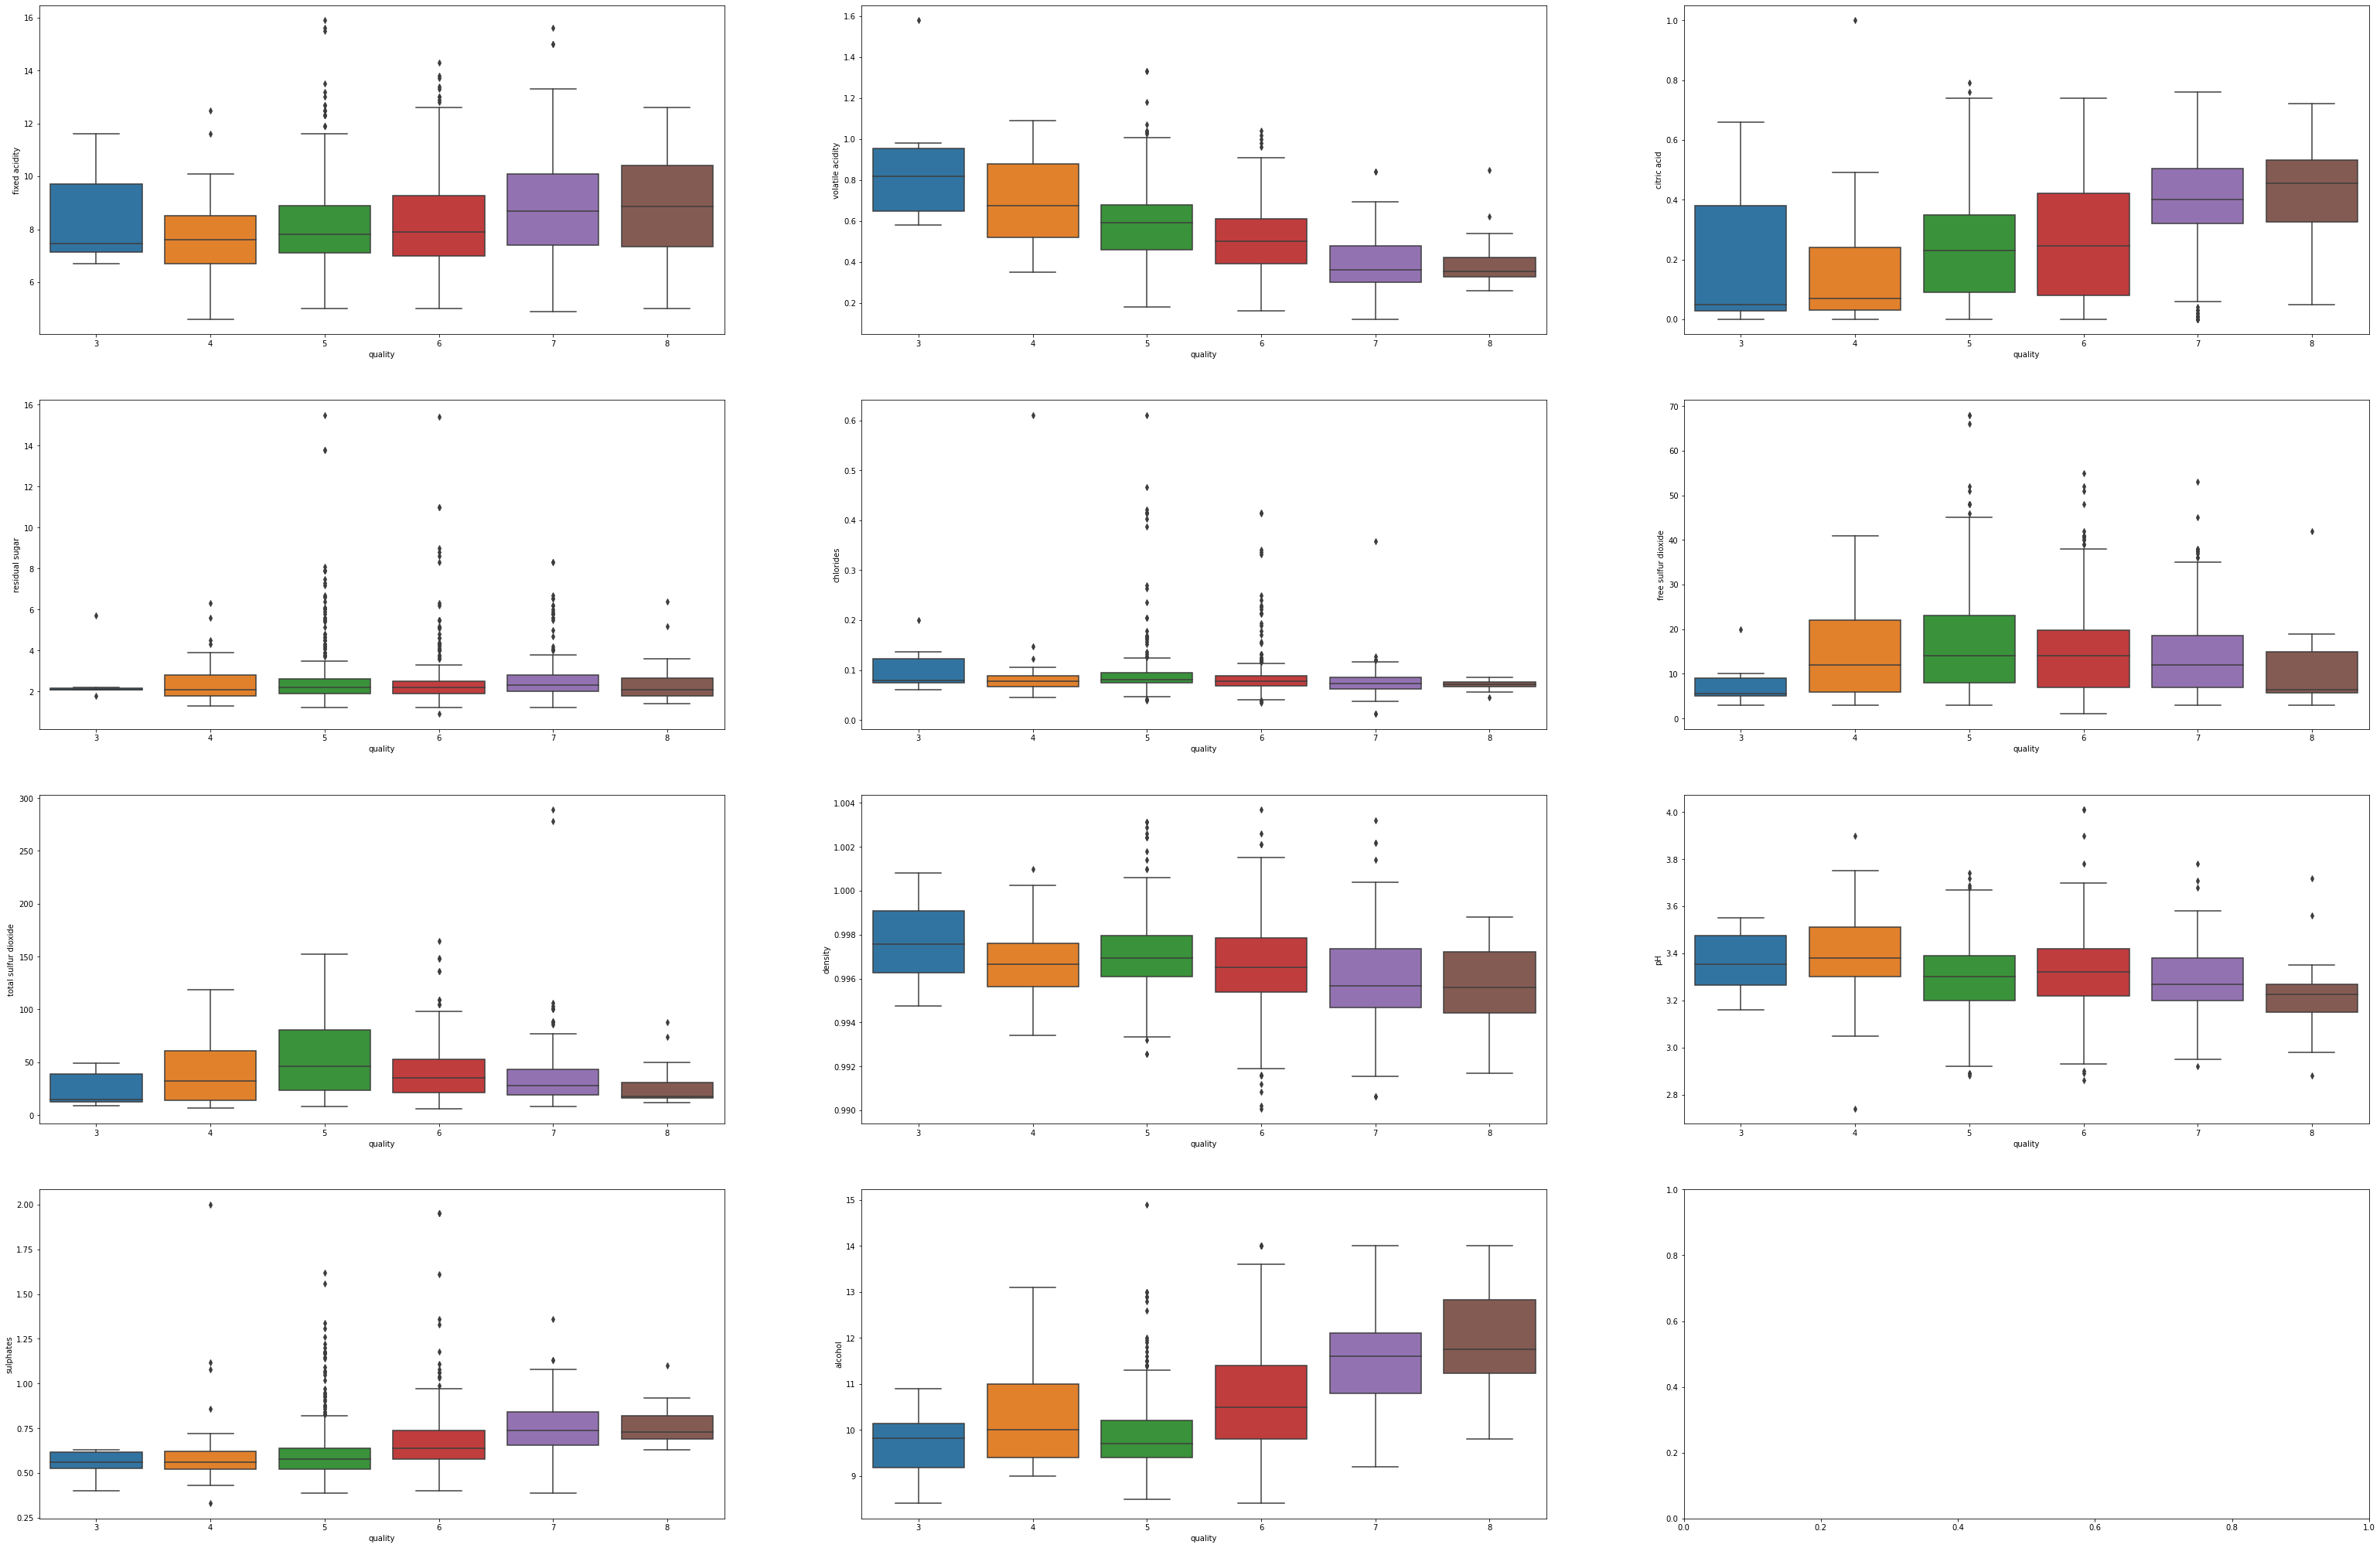

In [7]:
fig, axes = plt.subplots(4, 3, figsize=(54, 36))

sns.boxplot(ax=axes[0, 0], data=data, x='quality', y='fixed acidity')
sns.boxplot(ax=axes[0, 1], data=data, x='quality', y='volatile acidity')
sns.boxplot(ax=axes[0, 2], data=data, x='quality', y='citric acid')
sns.boxplot(ax=axes[1, 0], data=data, x='quality', y='residual sugar')
sns.boxplot(ax=axes[1, 1], data=data, x='quality', y='chlorides')
sns.boxplot(ax=axes[1, 2], data=data, x='quality', y='free sulfur dioxide')
sns.boxplot(ax=axes[2, 0], data=data, x='quality', y='total sulfur dioxide')
sns.boxplot(ax=axes[2, 1], data=data, x='quality', y='density')
sns.boxplot(ax=axes[2, 2], data=data, x='quality', y='pH')
sns.boxplot(ax=axes[3, 0], data=data, x='quality', y='sulphates')
sns.boxplot(ax=axes[3, 1], data=data, x='quality', y='alcohol')

### Baskılama İşlemi

In [8]:
for i in data.columns:
    if i != 'quality':
        Q1 = data[i].quantile(0.25)
        Q3 = data[i].quantile(0.75)
        IQR = Q3-Q1
        data[i][data[i] < (Q1 - 1.5 * IQR)] = Q1 - 2.5 * IQR #np.median(data[i])#Q1 - 1.5 * IQR
        data[i][data[i] > (Q3 + 1.5 * IQR)] = Q1 - 2.5 * IQR #np.median(data[i])#Q3 + 1.5 * IQR

### Baskılandıktan sonra verinin durumu 

<AxesSubplot:xlabel='quality', ylabel='alcohol'>

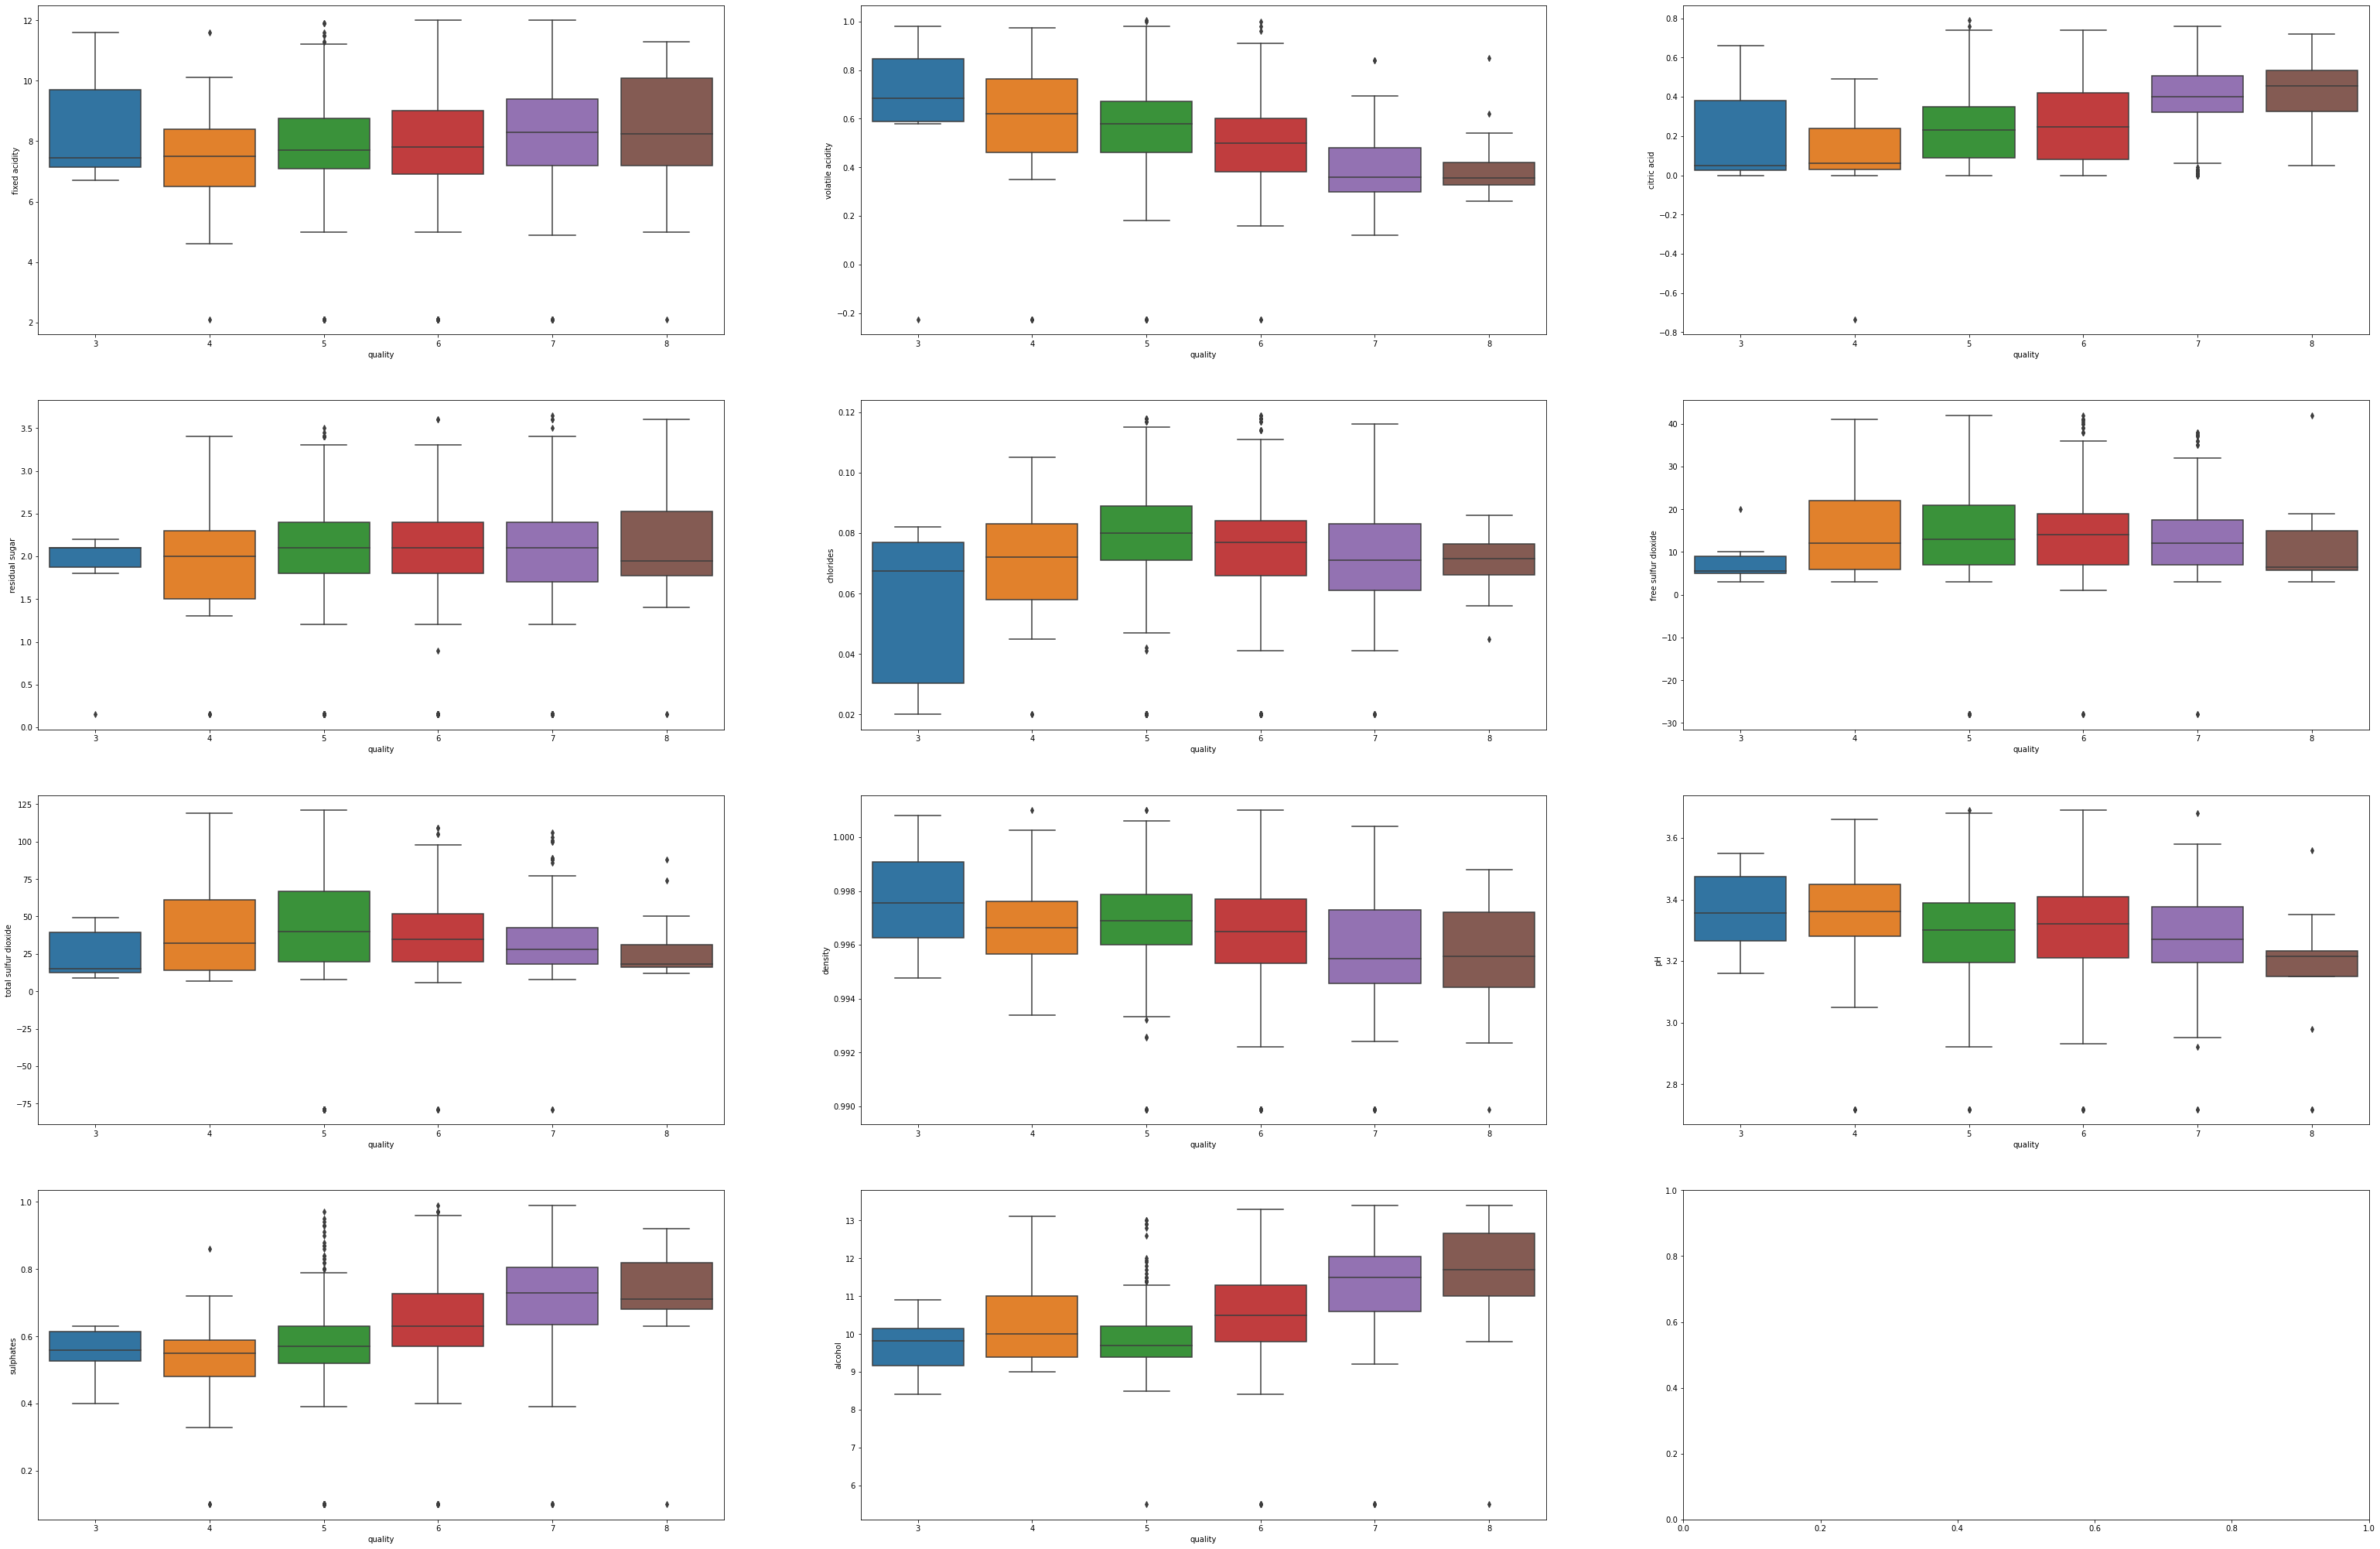

In [9]:
fig, axes = plt.subplots(4, 3, figsize=(54, 36))
sns.boxplot(ax=axes[0, 0], data=data, x='quality', y='fixed acidity')
sns.boxplot(ax=axes[0, 1], data=data, x='quality', y='volatile acidity')
sns.boxplot(ax=axes[0, 2], data=data, x='quality', y='citric acid')
sns.boxplot(ax=axes[1, 0], data=data, x='quality', y='residual sugar')
sns.boxplot(ax=axes[1, 1], data=data, x='quality', y='chlorides')
sns.boxplot(ax=axes[1, 2], data=data, x='quality', y='free sulfur dioxide')
sns.boxplot(ax=axes[2, 0], data=data, x='quality', y='total sulfur dioxide')
sns.boxplot(ax=axes[2, 1], data=data, x='quality', y='density')
sns.boxplot(ax=axes[2, 2], data=data, x='quality', y='pH')
sns.boxplot(ax=axes[3, 0], data=data, x='quality', y='sulphates')
sns.boxplot(ax=axes[3, 1], data=data, x='quality', y='alcohol')

### Genel datanın dağılımı

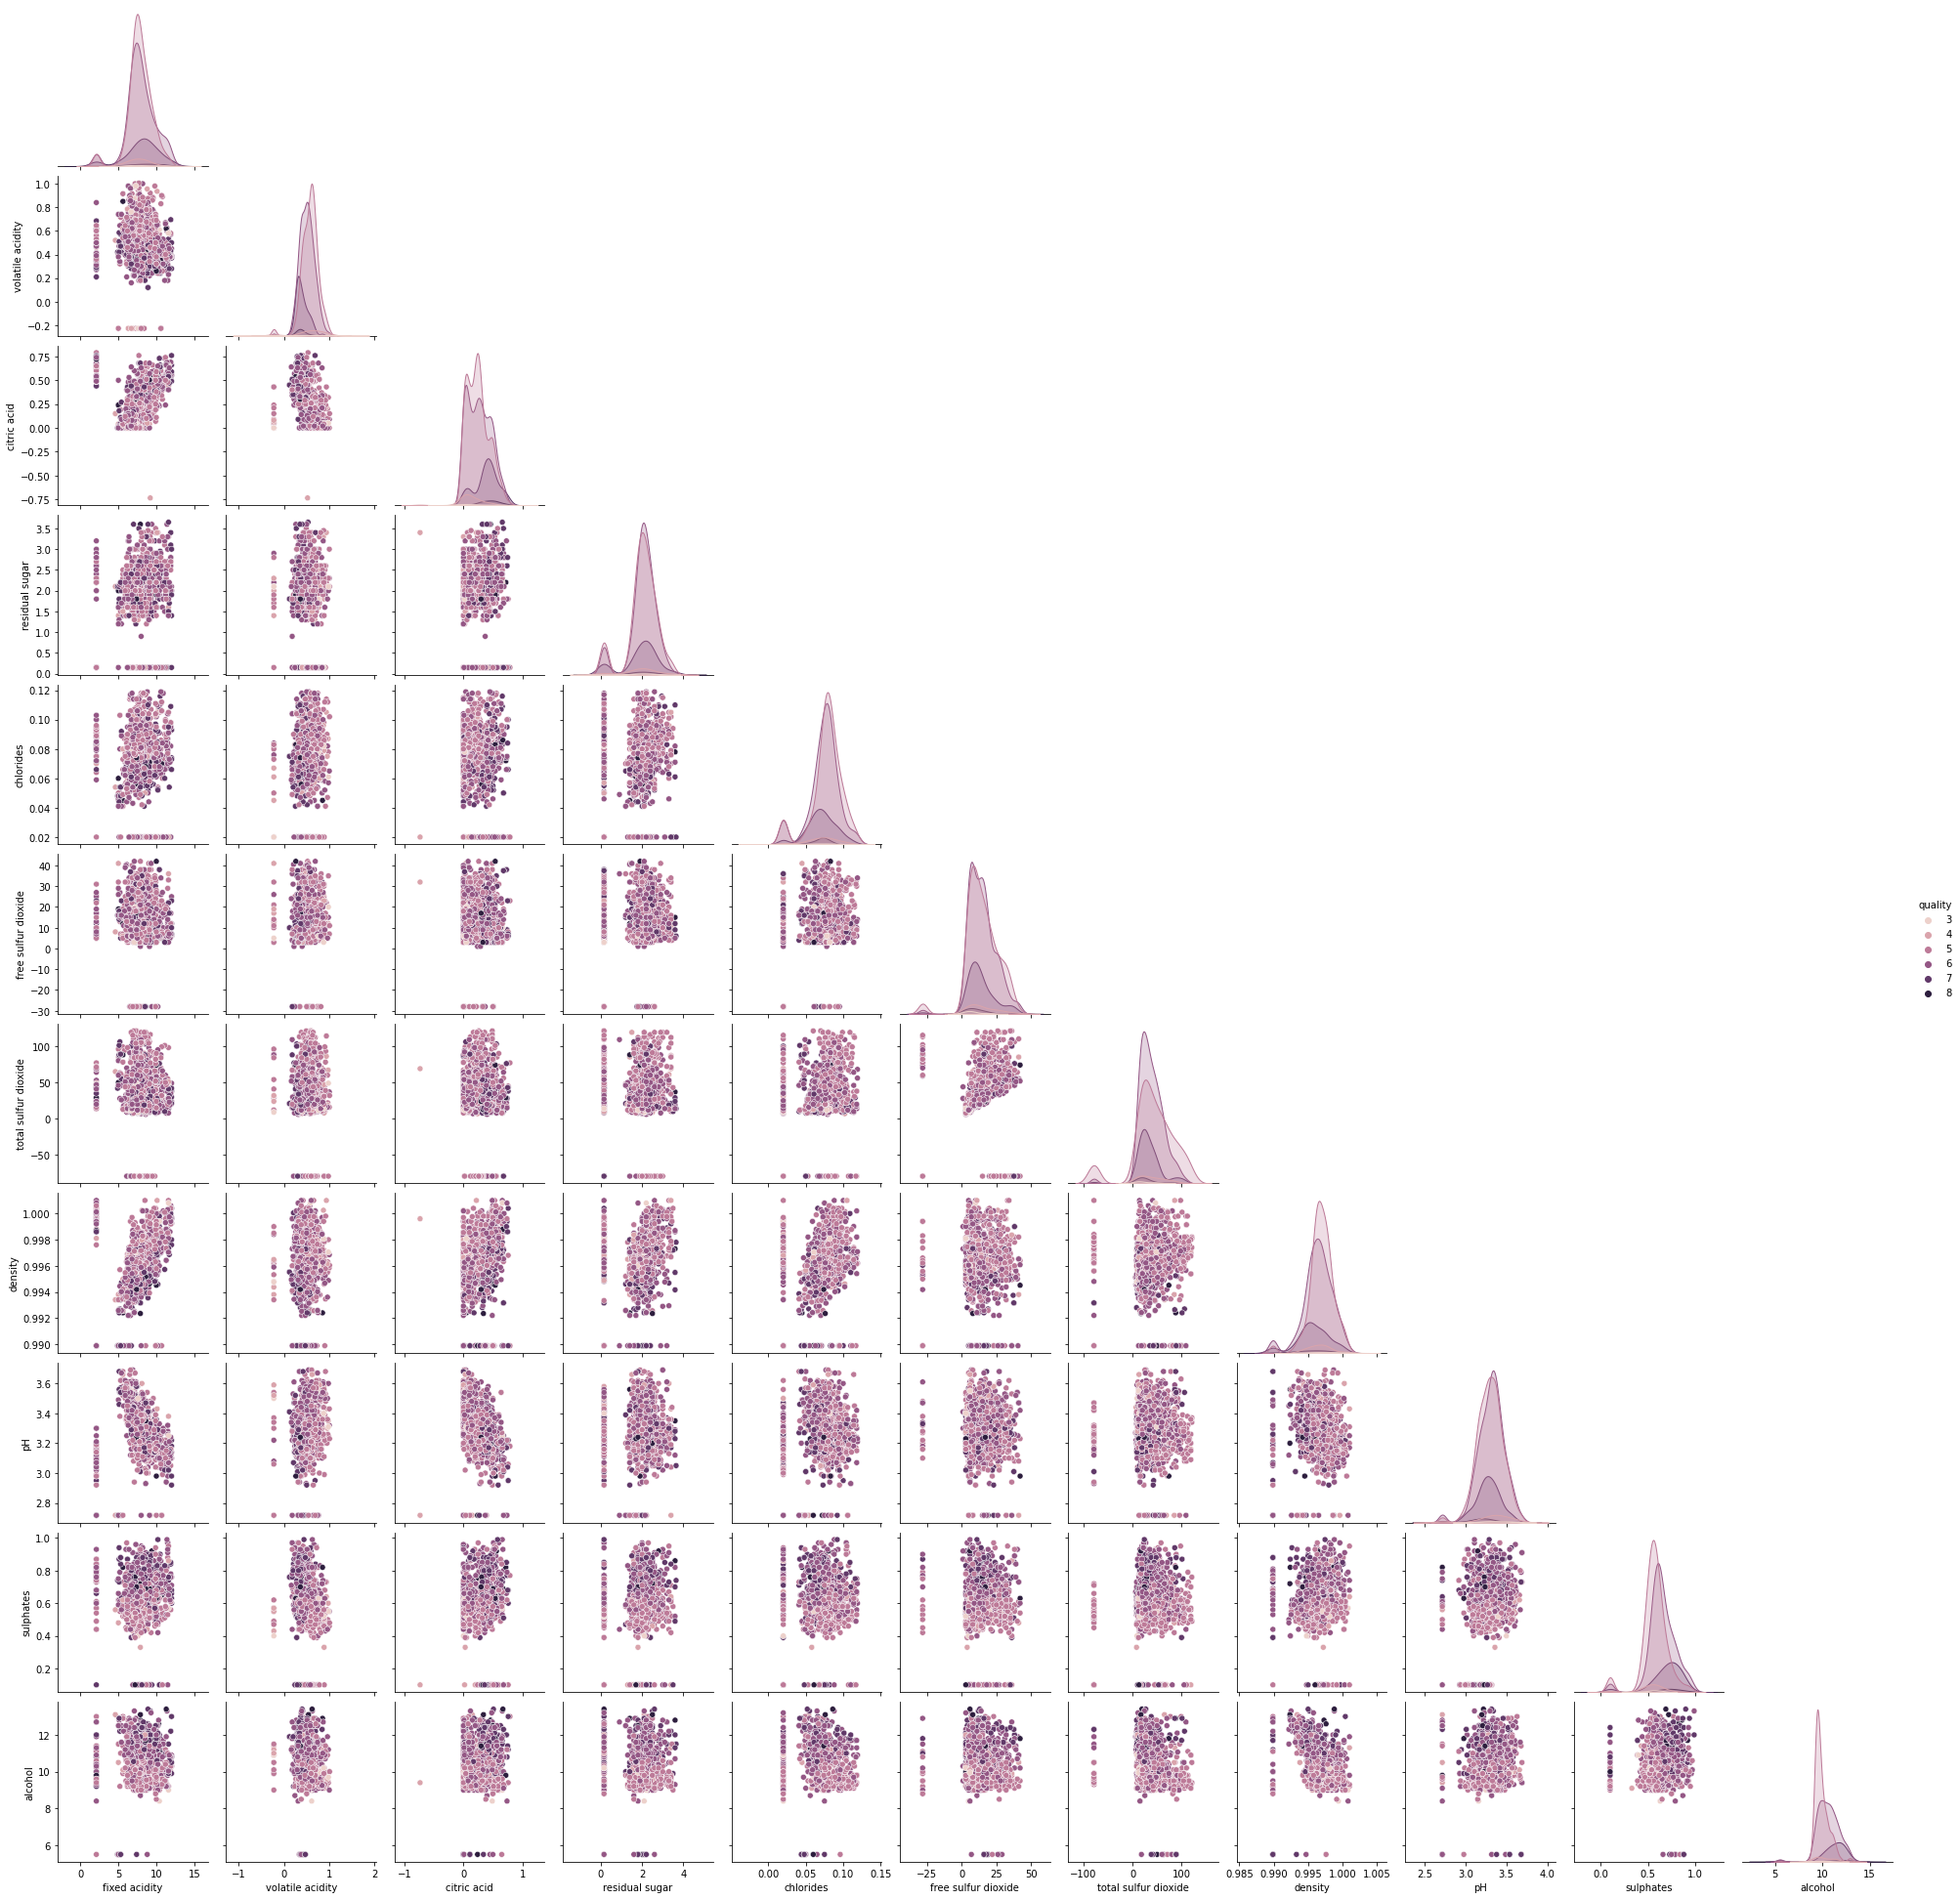

In [10]:
sns.pairplot(data,hue='quality',corner=True)
data = data.drop(columns=['quality'])

### Her bir feature ın ne kadar önemli olduğunu belirliyoruz 
### Burada extract ettiğim featureları model için kullanmayacağım

***XGBoostClassifier Feature Importance***

[21:36:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


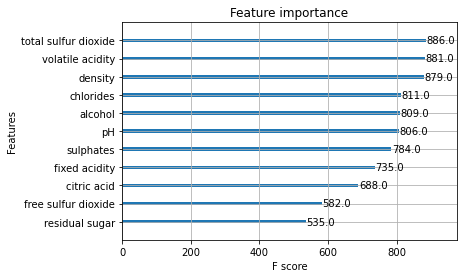

In [11]:
model = XGBClassifier()
model.fit(data, quality)

plot_importance(model)
plt.show()

***Her bir feature'ın birbiri ile  açıklanabilirliği-mutual information-***

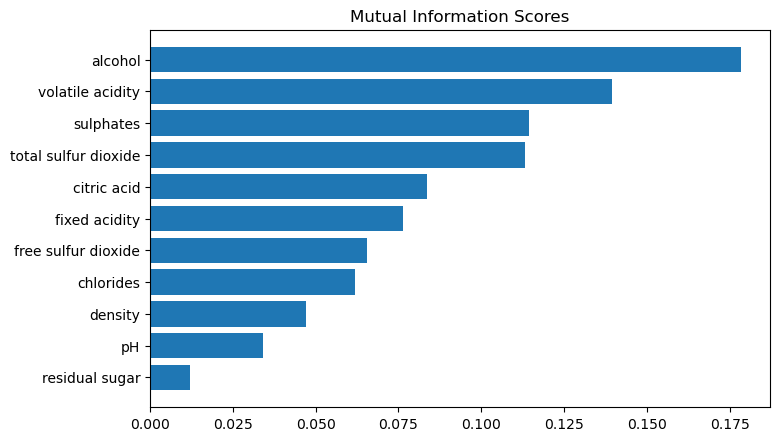

In [12]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="Mutual Information Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(data, quality)
mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

### Train-Test dataset ayrımı

In [13]:
scaler=StandardScaler()
data=scaler.fit_transform(data)
X_train, X_test, y_train, y_test = train_test_split(data, quality, test_size=0.10, random_state=13)

### Oversample yapmadan önceki DecisionTree

### Oversample yapmadan XGBoost classifier ve confusion matrix

In [24]:
print(np.unique(y_test))
print(np.unique(quality))

[4 5 6 7 8]
[3 4 5 6 7 8]


[22:08:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:08:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:08:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:08:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

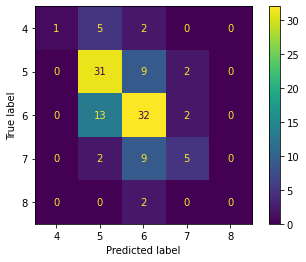

In [28]:
model = XGBClassifier(compute_sample_weight("balanced", y_train))
scores = cross_val_score(model, X_train, y_train, cv=10)
print(f"Scores: {scores}")
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_pred, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
plot_confusion_matrix(model, X_test, y_test)
print(classification_report(y_test,y_pred,target_names=["4","5","6","7","8"])) 


Scores: [0.62135922 0.55339806 0.59223301 0.54368932 0.50485437 0.59223301
 0.62135922 0.58252427 0.62745098 0.62745098]
Accuracy: 53.91%
              precision    recall  f1-score   support

           4       1.00      0.12      0.22         8
           5       0.61      0.74      0.67        42
           6       0.59      0.68      0.63        47
           7       0.56      0.31      0.40        16
           8       0.00      0.00      0.00         2

    accuracy                           0.60       115
   macro avg       0.55      0.37      0.38       115
weighted avg       0.61      0.60      0.57       115



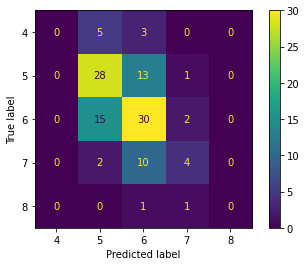

In [29]:
train_dataset = Pool(data=X_train,
                     label=y_train)

eval_dataset = Pool(data=X_test,
                    label=y_test)
model = CatBoostClassifier(iterations=10,
                           learning_rate=0.85,
                           depth=1,
                           verbose = False,
                           loss_function='MultiClass')

scores = cross_val_score(model, X_train, y_train, cv=10)
print(f"Scores: {scores}")
# Fit model
model.fit(train_dataset)
# Get predicted classes
preds_class = model.predict(eval_dataset)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_dataset)

# Get Acc
accuracy = accuracy_score(preds_class, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
#Get Confusion Matrix
plot_confusion_matrix(model, X_test, y_test) 
print(classification_report(y_test,y_pred,target_names=["4","5","6","7","8"])) 

### Normalizasyon, SMOTE  ve Train-Test Split

In [16]:
X_resampled_smote, y_resampled_smote = SMOTE(sampling_strategy='not majority').fit_resample(data, quality)
#X_resampled_adasyn, y_resampled_adasyn = ADASYN(sampling_strategy='not majority').fit_resample(data, quality)

scaler=StandardScaler()
X_resampled_smote = scaler.fit_transform(X_resampled_smote)
#scaler=StandardScaler()
#X_resampled_adasyn = scaler.fit_transform(X_resampled_adasyn)

X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_resampled_smote, y_resampled_smote, test_size=0.10, random_state=13)
#X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn = train_test_split(X_resampled_adasyn, y_resampled_adasyn, test_size=0.10, random_state=13)

### Oversample  XGBoost classifier 'Balanced olarak ayarlı' ve confusion matrix

In [31]:
print(np.unique(y_test_smote))

[3 4 5 6 7 8]


[22:13:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:13:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:13:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:13:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

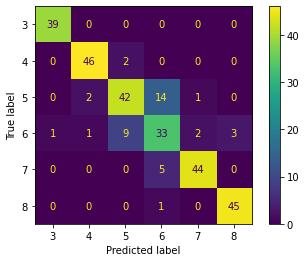

In [34]:
model = XGBClassifier()
scores = cross_val_score(model, X_train_smote, y_train_smote, cv=10)
print(f"Scores: {scores}")
model.fit(X_train_smote, y_train_smote,compute_sample_weight("balanced", y_train_smote))
# make predictions for test data
y_pred = model.predict(X_test_smote)
# evaluate predictions
accuracy = accuracy_score(y_pred, y_test_smote)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
plot_confusion_matrix(model, X_test_smote, y_test_smote) 
print(classification_report(y_test_smote,y_pred,target_names=["3","4","5","6","7","8"])) 

### Oversample DecisionTree  ve confusion matrix

Scores: [0.77777778 0.77394636 0.78544061 0.80842912 0.78544061 0.74712644
 0.79310345 0.79693487 0.76923077 0.78461538]
Accuracy: 0.7793103448275862
              precision    recall  f1-score   support

           3       0.97      0.95      0.96        39
           4       0.78      0.81      0.80        48
           5       0.67      0.63      0.65        59
           6       0.61      0.47      0.53        49
           7       0.77      0.94      0.84        49
           8       0.90      0.96      0.93        46

    accuracy                           0.78       290
   macro avg       0.78      0.79      0.78       290
weighted avg       0.77      0.78      0.77       290



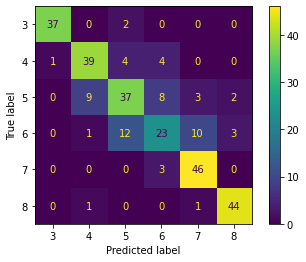

In [35]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X_train_smote, y_train_smote, cv=10)
print(f"Scores: {scores}")

# Train Decision Tree Classifer
clf = clf.fit(X_train_smote,y_train_smote)

#Predict the response for test dataset
y_pred = clf.predict(X_test_smote)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test_smote, y_pred))
plot_confusion_matrix(clf, X_test_smote, y_test_smote) 
print(classification_report(y_test_smote,y_pred,target_names=["3","4","5","6","7","8"])) 